<a href="https://colab.research.google.com/github/ankush170/PlantDiseasePredictor/blob/main/IcrisatModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip,RandomRotation,RandomZoom,RandomContrast
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.losses import BinaryCrossentropy
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
import math

In [ ]:
batch_size = 32
img_height = 224
img_width = 224

epochs=15

import os
import pathlib
data_dir = '/content/drive/MyDrive/model1'
data_dir= pathlib.Path(data_dir)

In [ ]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3727


In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(data_dir,
                                                       shuffle = True,
                                                       label_mode= "int",
  color_mode= 'rgb',
  labels= 'inferred',
                                                       validation_split = 0.2,
                                                       subset = 'training',
                                                       seed = 123,
                                                       image_size=(img_height, img_width),
                                                       batch_size=batch_size)

Found 3727 files belonging to 5 classes.
Using 2982 files for training.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  shuffle= True,
  validation_split=0.2,
  label_mode= "int",
  color_mode= 'rgb',
  labels= 'inferred',
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3727 files belonging to 5 classes.
Using 745 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['beans- Leaf Miner', 'beans- Mosaic', 'moong- Tobaco Caterpillar', 'sorghum- Anthracnose', 'sorghum- Fall Army Worm']


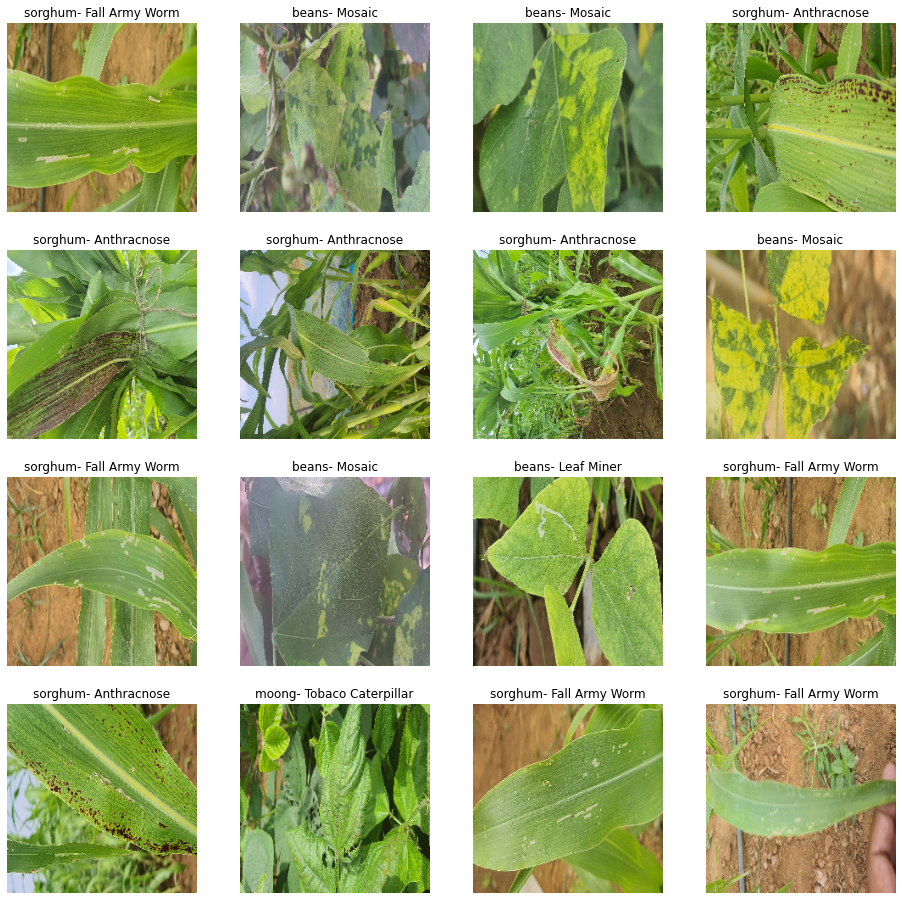

In [ ]:
plt.figure(figsize=(16,16))
for images, labels in train_ds.take(1):
  for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(images[i].numpy().astype('uint8'))
    plt.title(class_names[int(labels[i])])
    plt.axis('off')

In [ ]:
data_augmentation =Sequential( [
    RandomFlip("horizontal_and_vertical",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
   RandomRotation(0.2),
   RandomContrast(0.1),
   RandomZoom(0.2),
                               ])

In [ ]:
val_batches = tf.data.experimental.cardinality(val_ds)
test_dataset = val_ds.take(val_batches // 5)
val_ds = val_ds.skip(val_batches // 5)
print('Number of validation batches: %d' % tf.data.experimental.cardinality(val_ds))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 20
Number of test batches: 4


In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.cache().shuffle(1000).prefetch(buffer_size =AUTOTUNE)


normalization_layer=layers.Rescaling(1./255)

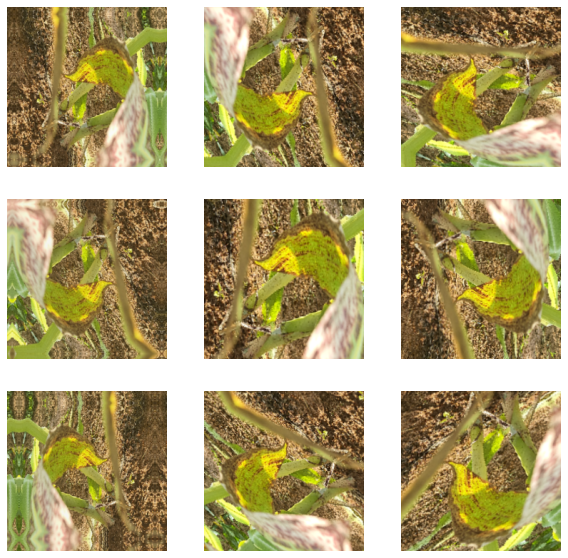

In [ ]:
for image, _ in train_ds.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [ ]:
normalized_ds= train_ds.map(lambda x,y: (normalization_layer(x),(y)))
image_batch,labels_batch = next(iter(normalized_ds))
first_image= image_batch[0]
print(np.min(first_image),np.max(first_image))

0.0 0.9972943


In [ ]:
num_classes = len(class_names)
base_mobilenetv2_model = Sequential([
                                 data_augmentation,
                        layers.Rescaling( scale=1./255),
                        layers.Resizing(img_height, img_width),

                        MobileNetV2(input_shape=(img_height, img_width,3), weights="imagenet", include_top=False)
] , name = 'base_mobilenetv2_model')

base_mobilenetv2_model.trainable = False
base_mobilenetv2_model.summary()


custom_mobilenetv2_model = Sequential([
        base_mobilenetv2_model,
        GlobalAveragePooling2D(),
                                                   
        Dense(512,activation='relu'),
        Dropout(0.2),
        Dense(num_classes , activation="softmax")
        ], name = "custom_mobilenetv2_model")

custom_mobilenetv2_model.summary()

Model: "base_mobilenetv2_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 resizing_1 (Resizing)       (None, 224, 224, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
Total params: 2,257,984
Trainable params: 0
Non-trainable params: 2,257,984
_________________________________________________________________
Model: "custom_mobilenetv2_model"
_________________________________________________________________


In [ ]:
custom_mobilenetv2_model.compile(optimizer=Adam(learning_rate=0.001*3),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                         metrics=['accuracy']
                         )

In [ ]:
early = EarlyStopping(monitor="val_loss", 
                      patience=math.floor(epochs*0.1))

learning_rate_reduction = ReduceLROnPlateau(monitor="val_loss",
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.3,
                                            min_lr=0.000001)
# saves the model in the current directory as the best validation accuracy is achieved.
modelcheck = ModelCheckpoint('best_model(MobileNetV2).hdf5', monitor='val_accuracy',verbose=1,save_best_only=True,mode='max')

In [ ]:
history = custom_mobilenetv2_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[modelcheck, learning_rate_reduction, early],
  verbose=1
)

Epoch 1/15
94/94 [==============================] - ETA: 0s - loss: 0.0732 - accuracy: 0.9728
Epoch 1: val_accuracy improved from 0.96272 to 0.97731, saving model to best_model(MobileNetV2).hdf5
94/94 [==============================] - 6s 61ms/step - loss: 0.0732 - accuracy: 0.9728 - val_loss: 0.0616 - val_accuracy: 0.9773 - lr: 0.0030
Epoch 2/15
94/94 [==============================] - ETA: 0s - loss: 0.0833 - accuracy: 0.9732
Epoch 2: val_accuracy improved from 0.97731 to 0.97893, saving model to best_model(MobileNetV2).hdf5
94/94 [==============================] - 6s 60ms/step - loss: 0.0833 - accuracy: 0.9732 - val_loss: 0.0694 - val_accuracy: 0.9789 - lr: 0.0030


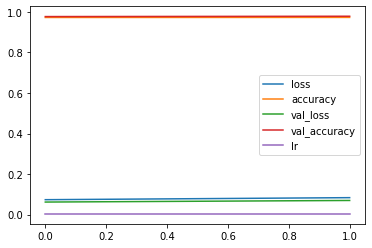

In [ ]:
pd.DataFrame(custom_mobilenetv2_model.history.history).plot()

In [ ]:
custom_mobilenetv2_model.layers[-1].output

<KerasTensor: shape=(None, 5) dtype=float32 (created by layer 'dense_3')>

In [ ]:
test_accu = custom_mobilenetv2_model.evaluate(test_dataset)

print("The testing accuracy is : ", test_accu[1]*100, "%")

4/4 [==============================] - 0s 56ms/step - loss: 0.0216 - accuracy: 1.0000
The testing accuracy is :  100.0 %


In [ ]:
custom_mobilenetv2_model.save("model(MobileNetV2).h5")
print('model saved to disk')

model saved to disk


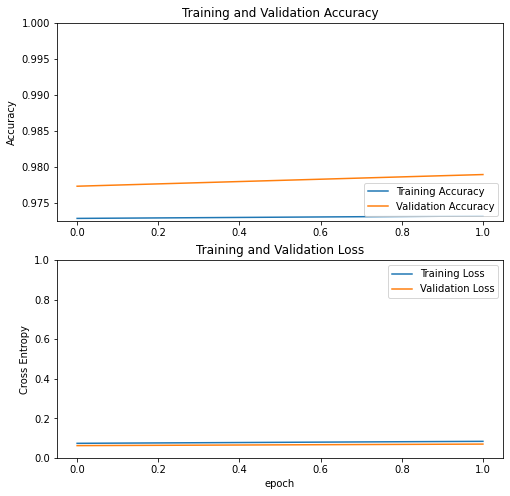

<Figure size 432x288 with 0 Axes>

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()
plt.savefig('metrices (MobileNetV2)')

In [ ]:
from numpy import loadtxt
from keras.models import load_model

# load model
model = load_model('/content/best_model(MobileNetV2).hdf5')
# summarize model.
model.summary()

Model: "custom_mobilenetv2_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 base_mobilenetv2_model (Seq  (None, 7, 7, 1280)       2257984   
 uential)                                                        
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_2 (Dense)             (None, 512)               655872    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 5)                 2565      
                                                                 
Total params: 2,916,421
Trainable params: 

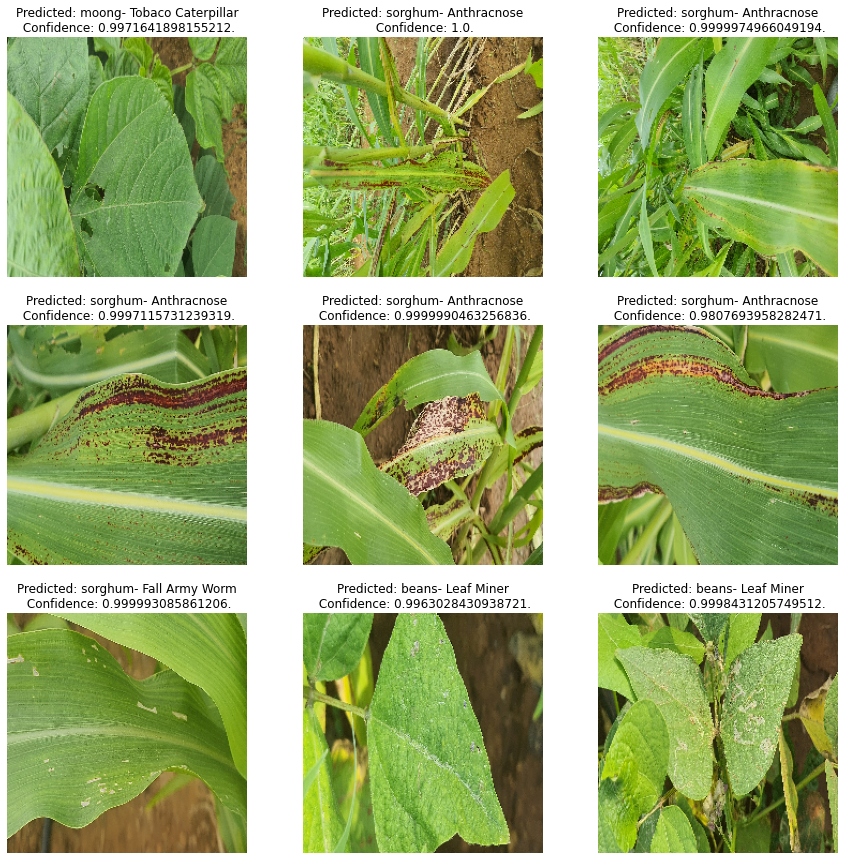

In [ ]:
from sklearn import preprocessing
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) #create a batch
    predictions = model.predict(img_array)

    for index,i in enumerate(predictions[0]):
      if i > 0.8:
        return class_names[index], i
    return 'No disease found', None
    # predicted_class = class_names[predictions[0]]
    # confidence = round(100 * (predictions[0]), 2)
    # return predicted_class, confidence

for images, labels in test_dataset.take(1):
    plt.figure(figsize=(15, 15))
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, predicted_probability = predict(model,
                                              images[i].numpy())
        
        actual_class = class_names[labels[i]]
        plt.title(f"Predicted: {predicted_class}\n Confidence: {predicted_probability}.")
        plt.axis("off")

    plt.savefig('classification_example(MobileNetV2).png')